In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
# load dataset
df=pd.read_csv("uber.csv")
print(df.head())
df.info()

   Unnamed: 0                  key  fare_amount          pickup_datetime  \
0    24238194  2015-05-07 19:52:06          7.5  2015-05-07 19:52:06 UTC   
1    27835199  2009-07-17 20:04:56          7.7  2009-07-17 20:04:56 UTC   
2    44984355  2009-08-24 21:45:00         12.9  2009-08-24 21:45:00 UTC   
3    25894730   2009-06-26 8:22:21          5.3  2009-06-26 08:22:21 UTC   
4    17610152  2014-08-28 17:47:00         16.0  2014-08-28 17:47:00 UTC   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.999817        40.738354         -73.999512         40.723217   
1        -73.994355        40.728225         -73.994710         40.750325   
2        -74.005043        40.740770         -73.962565         40.772647   
3        -73.976124        40.790844         -73.965316         40.803349   
4        -73.925023        40.744085         -73.973082         40.761247   

   passenger_count  
0                1  
1                1  
2                

In [117]:
# STEP 2 - DATA CLEANING
# drop unnamed column
df=df.drop(['Unnamed: 0','key'],axis=1)

# convert datetime to pandas datetime type
# pd.to_datetime - extracts exact date time month year from the object and converts into dtype - datetime
# error='coerce' - ensures that if any value is not converted to datetime it replaces with NaT - not  a time
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'],errors='coerce')


In [118]:
# Extracting the useful time-based features - hour,day,month,year
df['hour']=df['pickup_datetime'].dt.hour
df['day']=df['pickup_datetime'].dt.day
df['month']=df['pickup_datetime'].dt.month
df['year']=df['pickup_datetime'].dt.year


In [121]:
# Drop rows with missing or invalid data 
# keeps the only rows which satisfies the conditions below
df=df[(df['pickup_longitude'] != 0) & (df['dropoff_longitude'] != 0)]
df=df[(df['fare_amount']>0) & df['fare_amount'] <100]
df=df.dropna()
# returns a tuple with no. of rows and columns
print(df.shape)
print(df.describe())

(196036, 11)
         fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  196036.000000     196036.000000    196036.000000      196036.000000   
mean       11.342974        -73.929302        40.704969         -73.916356   
std         9.799464          5.454410         5.429111           8.521370   
min       -52.000000      -1340.648410       -74.015515       -3356.666300   
25%         6.000000        -73.992268        40.736395         -73.991592   
50%         8.500000        -73.982101        40.753287         -73.980521   
75%        12.500000        -73.968313        40.767541         -73.965315   
max       499.000000         57.418457      1644.421482        1153.572603   

       dropoff_latitude  passenger_count           hour            day  \
count     196036.000000    196036.000000  196036.000000  196036.000000   
mean          40.688176         1.685262      13.490736      15.705100   
std            3.996328         1.388181       6.514381       

In [123]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in km
    dlon = radians(lon2 - lon1)
    dlat = radians(lat2 - lat1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

df['distance_km'] = df.apply(lambda row: haversine(row['pickup_latitude'], row['pickup_longitude'],
                                                   row['dropoff_latitude'], row['dropoff_longitude']), axis=1)


<Axes: xlabel='fare_amount', ylabel='Count'>

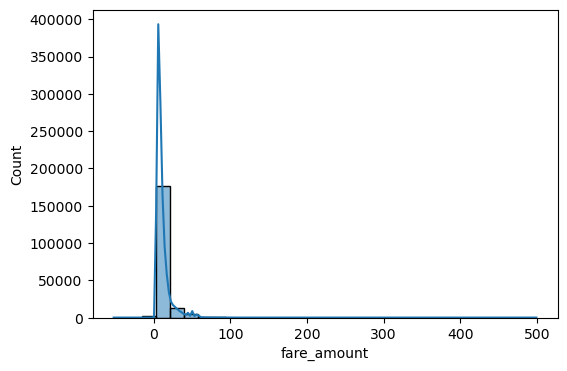

In [125]:
# Distribution of fare
plt.figure(figsize=(6,4))
sns.histplot(df['fare_amount'],bins=30,kde=True)

Text(0.5, 1.0, 'Passenger Count Distribution')

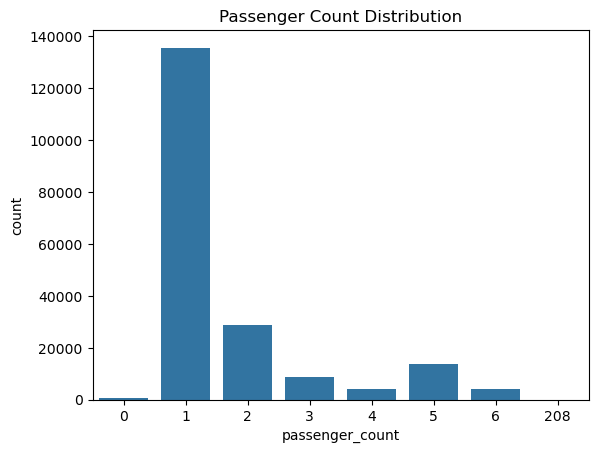

In [127]:
# Passenger Count
sns.countplot(x='passenger_count',data=df)
plt.title("Passenger Count Distribution")

Text(0.5, 1.0, 'Fare vs Passenger Count')

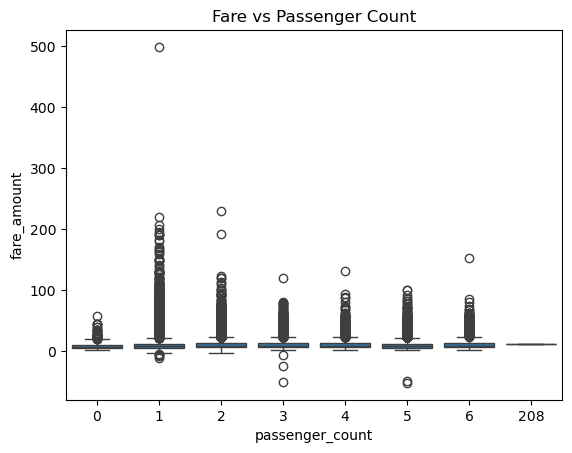

In [129]:
# relationship between fare and passenger count
sns.boxplot(x='passenger_count',y='fare_amount',data=df)
plt.title("Fare vs Passenger Count")

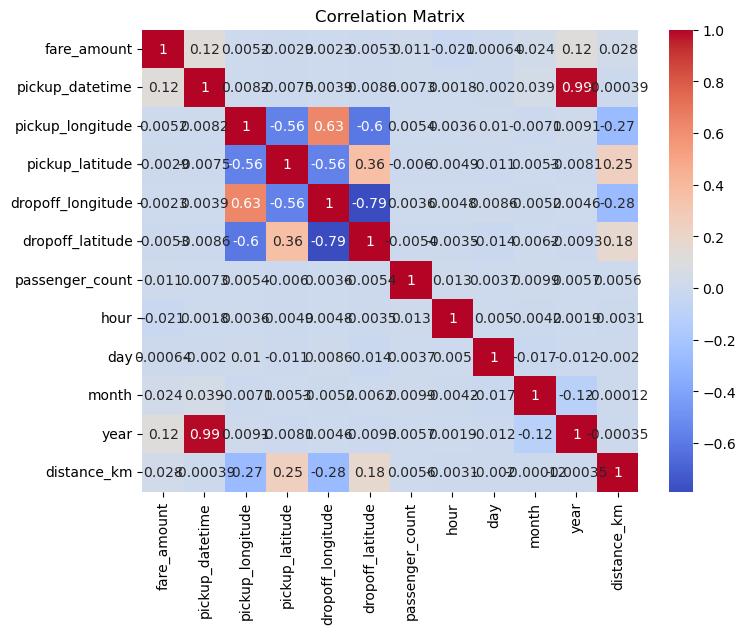

In [131]:
# correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [133]:
# STEP 4 - FEATURE SELECTION
X = df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
        'passenger_count', 'hour', 'day', 'month', 'year', 'distance_km']]
y = df['fare_amount']



In [136]:
# split and scale data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
# standardization - 
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [138]:
# train model without pca
model1=LinearRegression()
model1.fit(X_train_scaled,y_train)
y_pred1=model1.predict(X_test_scaled)
print("Model without PCA:")
print("R2 score:",r2_score(y_test,y_pred1))
print("MSE: ",mean_squared_error(y_test,y_pred1))



Model without PCA:
R2 score: 0.017736160520977484
MSE:  93.66479122016597


In [140]:
# apply pca
pca=PCA(n_components=0.95) #keeps 95% variance
X_train_pca=pca.fit_transform(X_train_scaled)
X_test_pca=pca.transform(X_test_scaled)
print("Original features:\n",X_train_scaled[1])
print("Reduced features:\n",X_train_pca[1])

Original features:
 [-0.00629582  0.01272986 -0.00706889  0.02134528 -0.48710467  0.69257504
 -0.65726046  0.20852244 -1.47489644 -0.03272702]
Reduced features:
 [ 0.03330347  1.18570108 -0.10729487  0.35627199 -0.97783208  0.91475636
 -0.17571463 -0.00952224 -0.01249592]


In [142]:
# train model with pca
model2=LinearRegression()
model2.fit(X_train_pca,y_train)
y_pred2=model2.predict(X_test_pca)
print("Model with PCA:")
print("R2 score:",r2_score(y_test,y_pred2))
print("MSE: ",mean_squared_error(y_test,y_pred2))

Model with PCA:
R2 score: 0.017738101754805613
MSE:  93.66460611179293
